* Remove inner label, change colormap for scatter plot.

In [1]:
import os
import glob

import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import datetime

import sys
sys.path.append('/data/jieliu/MEOPAR/IOS/')
import comparisons

from salishsea_tools import tidetools, viz_tools,geo_tools
import seaborn as sns
from scipy import interpolate as interp

import ACTDR
import pandas as pd
%matplotlib inline
degree_sign= u'\N{DEGREE SIGN}'+' W'
degree= u'\N{DEGREE SIGN}'

/ocean/jieliu/Anaconda/envs/mpython2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/ocean/jieliu/Anaconda/envs/mpython2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.6, rc={"lines.linewidth": 2.5})


In [3]:
paths = {'RFdaily': '/data/jieliu/MEOPAR/IOS/octRFdaily/',
         '1e-05': '/data/jieliu/MEOPAR/IOS/oct1e05/',
          '1e-051e-06':'/data/jieliu/MEOPAR/IOS/oct1e061e05/'}
grid_B = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_10reduceviscosity/mesh_mask.nc')
FIRST_NOWCAST = datetime.datetime(2014, 10,27)


In [4]:
def get_model_cast(year, month, day, data,lon,lat, field,model_path, cast):
    """Get the model daily mean, max and min corresponding to given year, month, day and lat/lon"""
    
    if field =='Salinity':
        var = 'vosaline'
    elif field == 'Temperature':
        var = 'votemper'
        
    date = datetime.datetime(year, month, day)
    data_m = data[data['Month'] == month]
    num_casts = len(data_m.index)
    bathy, X, Y= tidetools.get_bathy_data(grid_B)
    j, i = geo_tools.find_closest_model_point(lon, lat, X, Y, land_mask=bathy.mask)
    #print(j,i)
    filename_pattern = '1h_Plume{i}_T.nc'
    if j == 443 and i == 259:
        path = os.path.join(model_path, filename_pattern.format( i = 1))
    if j == 440 and i == 299:
        path = os.path.join(model_path, filename_pattern.format( i = 2))
    if j == 447 and i == 244:
        path = os.path.join(model_path, filename_pattern.format( i = 6))
    if j == 423 and i == 263:
        path = os.path.join(model_path, filename_pattern.format( i = 11))
    if j == 423 and i == 276:
        path = os.path.join(model_path, filename_pattern.format( i = 12))
    if j == 426 and i == 309:
        path = os.path.join(model_path, filename_pattern.format( i = 40))
    print (path)
        # print(j,i)
    ## for new result
    depths = mesh.variables['gdept'][0,:,j,i]
    new_file = nc.Dataset(path);
    var_model = new_file.variables[var][:,:,0,0]
    var_model, tmask = mask_model(j,i, var_model)
    # Daily mean/min/max
    min_daily = np.min(var_model[(day-1)*24:day*24,:], axis=0)
    max_daily = np.max(var_model[(day-1)*24:day*24,:], axis=0)
    mean_daily = np.mean(var_model[(day-1)*24:day*24,:], axis=0)

    return mean_daily, max_daily, min_daily, depths, tmask


In [5]:
def mask_model(j,i,var_model):
    """Mask a model variable at a grid point"""
    
    tmask = np.abs(1-mesh.variables['tmask'][:, :, j, i])
    tmask = tmask + np.zeros(var_model.shape)
    var_masked = np.ma.array(var_model, mask=tmask)
    return var_masked, tmask[0,:]


In [6]:
def prepare_cast_comparison(dep_obs, var_obs, year, month, day, lon, lat, cast,data,field,model_path):
    """Gather model and observed cast data for comparison"""
    
    # model data 
    mean_mod, max_mod, min_mod, dep_mod, tmask = get_model_cast(year, month, day, data,lon, lat,\
                                                        field, model_path,cast)
    #print(len(dep_obs),len(var_obs))
    # interp observations
    interp_obs = comparisons.interpolate_depth(var_obs, dep_obs, dep_mod)
    interp_obs = np.ma.array(interp_obs, mask=tmask)
    
    return interp_obs, mean_mod, max_mod, min_mod, dep_mod


In [7]:
ACTDR.load_dat('/ocean/jieliu/research/meopar/river-discharge/SOG_to.dat')


('> open ', '/ocean/jieliu/research/meopar/river-discharge/SOG_to.dat')
> load CTD_DAT
> load STANDARD_KEYS
('> close ', '/ocean/jieliu/research/meopar/river-discharge/SOG_to.dat')
> complete


In [8]:
data = pd.DataFrame(ACTDR.CTD_DAT)

data_fall = data[(data.Year>=2014) & (data.Month >=10) & (data.Month <12)]


In [9]:
import scipy.io as sio
rbr = sio.loadmat('/ocean/jieliu/research/meopar/surface current/rbr.mat')

value = rbr['a']


# Load three RBR into pandas frame

In [10]:
dep = [value[215:380,0].tolist()]
sal = [value[215:380,1].tolist()]
df1 = pd.DataFrame({'Day':2,'Depth':dep,'ID':20141002,'Latitude':49.1292,'Longitude':-123.2119,\
                                 'Month':10,'Salinity':sal,'Temperature':0,'Year':2014},index = ['2626']) #will work


In [11]:
dep2 = [value[569:422:-1,0].tolist()]
sal2 = [value[569:422:-1,1].tolist()]
df2 = pd.DataFrame({'Day':14,'Depth':dep2,'ID':20141014,'Latitude':49.1292,'Longitude':-123.2119,\
                                 'Month':10,'Salinity':sal2,'Temperature':0,'Year':2014},index = ['2627']) #will work


In [12]:
dep3 = [value[858:569:-1,0].tolist()]
sal3 = [value[858:569:-1,1].tolist()]
df3 = pd.DataFrame({'Day':29,'Depth':dep3,'ID':20141029,'Latitude':49.1292,'Longitude':-123.2119,\
                                 'Month':10,'Salinity':sal3,'Temperature':0,'Year':2014},index = ['2628']) #will work


In [13]:
data_fall = data_fall.append(df1)
data_fall = data_fall.append(df2)
data_fall = data_fall.append(df3)


In [14]:
month = 10
lon_min=-123.622
lon_max=-123.2
lat_min=49.
lat_max=49.19
data_region  = comparisons.isolate_region(data_fall,lon_min, lon_max, lat_min, lat_max)
data_m = data_region[data_region['Month'] == month] ## only extract oct no dec included
data_m = data_m.drop(2517) ## I found the label of that unwanted grid point in advance and drop it out


In [15]:
def scatter_compare(data, month,field, cmin, cmax, model_path,ax, units):
    sal_flags=[]
    cast = 0
    for dep_obs, var_obs, lon, lat, year, day, num in zip(data['Depth'],
                                                        data[field],
                                                        data['Longitude'],
                                                        data['Latitude'],
                                                        data['Year'],
                                                        data['Day'],
                                                        range(1,9)):

        interp_obs, mean_mod, max_mod, min_mod, dep_mod = prepare_cast_comparison(dep_obs, var_obs,
                                            year, month, day,lon, lat, cast,data,field,model_path)
        thres=1; date=datetime.datetime(year, month, day)
        if field == 'Salinity':
            flag, k=classify_surface_salinity(interp_obs, mean_mod, max_mod, min_mod, thres)
            if flag == 0:
                print('Salinity within {} at depth {}, {}, {}, {}'.format(thres, dep_mod[k], lon, lat, date))
            if flag == 1:
                print('Too salty at depth {}, {}, {}, {}'.format(dep_mod[k], lon, lat, date))
            if flag == -1:
                print('Too fresh at depth {}, {}, {}, {}'.format(dep_mod[k], lon, lat, date))
            sal_flags.append(flag)
        ax.errorbar(interp_obs, mean_mod, yerr=[mean_mod-min_mod,max_mod-mean_mod ], fmt='k:',marker='', 
                         zorder=0, ecolor='gray',lw=1)
        sc = ax.scatter(interp_obs, mean_mod, marker='o', edgecolor='',c= dep_mod, 
                             norm=mcolors.LogNorm(), cmap='viridis_r', vmin=0.5, vmax=300, s=90)
        
        for i in range(4):
            if np.isnan(interp_obs[i]):
                pass
            else:
                ax.text(interp_obs[i],mean_mod[i],str(num),fontsize = 14)
                break
        ax.set_xlim([cmin, cmax])
        ax.set_ylim([cmin, cmax])
        

        ax.plot([cmin, cmax],[cmin, cmax], 'r-',zorder=0)
        cast = cast+1

    #cb = plt.colorbar(sc, ax=ax)
    #ticks = [1, 10, 25, 50, 100, 200, 400]
    #cb.set_ticks(ticks)
    #cb.set_ticklabels(ticks)
    #cb.set_label('Depth (m)')
    #ax.set_xlabel('Observed Practical {} '.format(field))
    #ax.set_ylabel('Modeled Practical {} '.format(field))
      
    
    return sal_flags, interp_obs,mean_mod, sc


In [16]:
def results(data, month,field, cmin, cmax, model_path, units):
    sal_flags=[];
    cast = 0;
    obs_values = {}
    mod_values = {}
    for dep_obs, var_obs, lon, lat, year, day,ID in zip(data['Depth'],
                                                        data[field],
                                                        data['Longitude'],
                                                        data['Latitude'],
                                                        data['Year'],
                                                        data['Day'],
                                                        data['ID']):

        interp_obs, mean_mod, max_mod, min_mod, dep_mod = prepare_cast_comparison(dep_obs, var_obs,
                                            year, month, day,lon, lat, cast,data,field,model_path)
        thres=1; date=datetime.datetime(year, month, day)
        if field == 'Salinity':
            flag, k=classify_surface_salinity(interp_obs, mean_mod, max_mod, min_mod, thres)
            if flag == 0:
                print('Salinity within {} at depth {}, {}, {}, {}'.format(thres, dep_mod[k], lon, lat, date))
            if flag == 1:
                print('Too salty at depth {}, {}, {}, {}'.format(dep_mod[k], lon, lat, date))
            if flag == -1:
                print('Too fresh at depth {}, {}, {}, {}'.format(dep_mod[k], lon, lat, date))
            sal_flags.append(flag)
            
        obs_values[ID] = interp_obs
        mod_values[ID] = mean_mod
        dep = dep_mod
        
    return obs_values,mod_values,dep


In [17]:
def compare_region(data, month,lon_min, lon_max, lat_min, lat_max,model_path, title, smin=0, smax=32, tmin=8, tmax=16):
    cmapp = sns.diverging_palette(220, 20,as_cmap=True)
    data_region  = comparisons.isolate_region(data,lon_min, lon_max, lat_min, lat_max)
    data_m = data_region[data_region['Month'] == month] ## only extract oct no dec included
    data_m = data_m.drop(2517) ## I found the label of that unwanted grid point in advance and drop it out
    #sal
    fig1,(ax2,ax1) = plt.subplots(1,2,figsize = (15,4))
    field = 'Salinity'; 
    sal_flags,O,S,sc=scatter_compare(data_m, month,field, smin,smax,model_path,ax2,'psu')

    for i, num in zip(range(8),range(1,9)):
        ax1.scatter(data_m['Longitude'][i], data_m['Latitude'][i], s=90, c=sal_flags[i],cmap=cmapp,vmin=-1,vmax=1)
        if i>=5 and i <=7:
            ax1.text(data_m['Longitude'][i]-0.009*i,data_m['Latitude'][i]+0.02, str(num),fontsize = 12)
        else:
            ax1.text(data_m['Longitude'][i]-0.02,data_m['Latitude'][i]+0.02, str(num),fontsize = 12)
    #ax1.scatter(data_m['Longitude'], data_m['Latitude'], s=90, c=sal_flags,cmap=cmapp,vmin=-1,vmax=1)    
    viz_tools.plot_coastline(ax1,grid_B, coords='map')
    ax1.set_xlim([-124, -122.8])
    ax1.set_ylim([48.5, 49.4])
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    ax1.set_title(title)
    return fig1, ax1


In [18]:
def get_results(data, month,lon_min, lon_max, lat_min, lat_max,model_path, title, smin=0, smax=32, tmin=8, tmax=16):
    cmapp = sns.diverging_palette(220, 20,as_cmap=True)
    data_region  = comparisons.isolate_region(data,lon_min, lon_max, lat_min, lat_max)
    data_m = data_region[data_region['Month'] == month] ## only extract oct no dec included
    data_m = data_m.drop(2517) ## I found the label of that unwanted grid point in advance and drop it out
    #sal
    field = 'Salinity'; 
    obs_values,mod_values,dep=results(data_m, month,field, smin,smax,model_path,'psu')

    return obs_values,mod_values,dep


In [19]:
def classify_surface_salinity(interp_obs, mean_mod, max_mod, min_mod, thres):

    interp_obs = np.ma.masked_invalid(interp_obs)
    nonmasked = np.ma.flatnotmasked_edges(interp_obs)
    k=nonmasked[0]
    if (min_mod[k] -interp_obs[k] >thres) :
        flag = 1 #salty surface
    elif (max_mod[k] - interp_obs[k] )<-thres:
        flag = -1 #fresh surface
    else:
        flag =0  #ok
    
    return flag, k


In [20]:
def interpolate_depth(variable, depth_array, depth_new):
    """ interpolates a variable depth profile field to desire depth.
    Ideally the variable is already masked but this method masks invalid data.
    """
    # mask
    var_mask = np.ma.masked_invalid(variable)
    d_mask = np.ma.masked_invalid(depth_array)
    print(len(d_mask[~d_mask.mask]),len( var_mask[~var_mask.mask]))
    f = interp.interp1d(d_mask[~d_mask.mask], 
                        var_mask[~var_mask.mask],bounds_error=False)
    var_new = f(depth_new)
    
    return var_new


* Test

/data/jieliu/MEOPAR/IOS/octRFdaily/1h_Plume1_T.nc
Too fresh at depth 3.50003051758, -123.527, 49.1026666667, 2014-10-01 00:00:00
/data/jieliu/MEOPAR/IOS/octRFdaily/1h_Plume2_T.nc
Too fresh at depth 3.50003051758, -123.310333333, 49.1673333333, 2014-10-01 00:00:00
/data/jieliu/MEOPAR/IOS/octRFdaily/1h_Plume6_T.nc
Salinity within 1 at depth 3.50003051758, -123.62, 49.0896666667, 2014-10-03 00:00:00
/data/jieliu/MEOPAR/IOS/octRFdaily/1h_Plume11_T.nc
Too salty at depth 3.50003051758, -123.4385, 49.03, 2014-10-28 00:00:00
/data/jieliu/MEOPAR/IOS/octRFdaily/1h_Plume12_T.nc


/ocean/jieliu/Anaconda/envs/mpython2/lib/python2.7/site-packages/numpy/ma/core.py:4144: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


Too salty at depth 2.50001144409, -123.372666667, 49.0546666667, 2014-10-28 00:00:00
/data/jieliu/MEOPAR/IOS/octRFdaily/1h_Plume40_T.nc
Salinity within 1 at depth 1.50000309944, -123.2119, 49.1292, 2014-10-02 00:00:00
/data/jieliu/MEOPAR/IOS/octRFdaily/1h_Plume40_T.nc
Too salty at depth 1.50000309944, -123.2119, 49.1292, 2014-10-14 00:00:00
/data/jieliu/MEOPAR/IOS/octRFdaily/1h_Plume40_T.nc
Too salty at depth 1.50000309944, -123.2119, 49.1292, 2014-10-29 00:00:00
/data/jieliu/MEOPAR/IOS/oct1e05/1h_Plume1_T.nc
Too fresh at depth 3.50003051758, -123.527, 49.1026666667, 2014-10-01 00:00:00
/data/jieliu/MEOPAR/IOS/oct1e05/1h_Plume2_T.nc
Too fresh at depth 3.50003051758, -123.310333333, 49.1673333333, 2014-10-01 00:00:00
/data/jieliu/MEOPAR/IOS/oct1e05/1h_Plume6_T.nc
Salinity within 1 at depth 3.50003051758, -123.62, 49.0896666667, 2014-10-03 00:00:00
/data/jieliu/MEOPAR/IOS/oct1e05/1h_Plume11_T.nc
Too salty at depth 3.50003051758, -123.4385, 49.03, 2014-10-28 00:00:00
/data/jieliu/MEOPAR/I

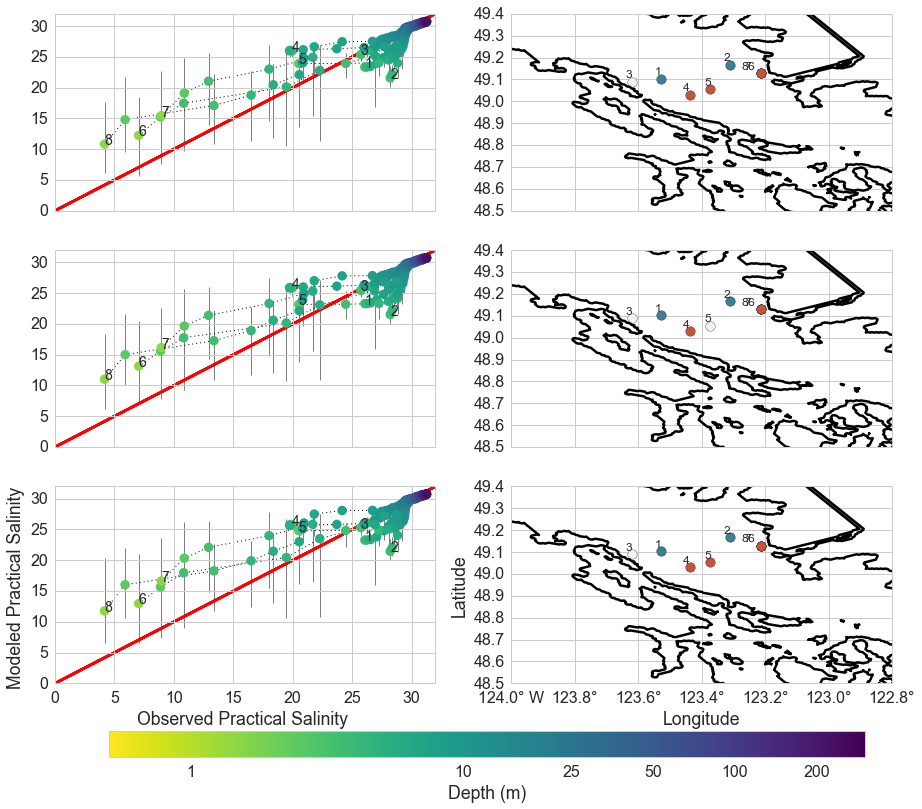

In [21]:
cmapp = sns.diverging_palette(220, 20,as_cmap=True)
cmapp = sns.diverging_palette(220, 20,as_cmap=True)
field = 'Salinity'; 
smin = 0
smax = 32
tmin=8
tmax=16

fig, axs = plt.subplots(3,2,figsize = (15,12))
for ax1,ax2, model_path in zip([axs[0,1],axs[1,1],axs[2,1]],\
                               [axs[0,0],axs[1,0],axs[2,0]],\
                               [paths['RFdaily'],paths['1e-05'],paths['1e-051e-06']]):
    sal_flags,O,S, sc=scatter_compare(data_m, month,field, smin,smax,model_path,ax2,'psu')      
    for i, num in zip(range(8),range(1,9)):
        ax1.scatter(data_m['Longitude'][i], data_m['Latitude'][i], s=90, c=sal_flags[i],cmap=cmapp,vmin=-1,vmax=1)
        if i>=5 and i <=7:
            ax1.text(data_m['Longitude'][i]-0.009*i,data_m['Latitude'][i]+0.02, str(num),fontsize = 12)
        else:
            ax1.text(data_m['Longitude'][i]-0.02,data_m['Latitude'][i]+0.02, str(num),fontsize = 12)  
    viz_tools.plot_coastline(ax1,grid_B, coords='map')
    ax1.set_xlim([-124, -122.8])
    ax1.set_xticklabels([str(124.) +degree_sign, str(123.8)+degree,str(123.6)+degree,\
                        str(123.4)+degree,str(123.2)+degree,str(123.)+degree,str(122.8)+degree])
    ax1.set_ylim([48.5, 49.4])


cbar_ax = fig.add_axes([0.175, 0.04, 0.7, 0.03])
cbar = fig.colorbar(sc, cax=cbar_ax,orientation = 'horizontal')
ticks = [1, 10, 25, 50, 100, 200, 400]
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticks)
cbar.set_label('Depth (m)')
                               
ax = axs[2,0]
ax.set_xlabel('Observed Practical {} '.format(field))
ax.set_ylabel('Modeled Practical {} '.format(field))     
for ax in [axs[0,0],axs[1,0],axs[0,1],axs[1,1]]:
    plt.setp( ax.get_xticklabels(), visible=False)
ax = axs[2,1]
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Plot

/data/jieliu/MEOPAR/IOS/octRFdaily/1h_Plume1_T.nc
Too fresh at depth 3.50003051758, -123.527, 49.1026666667, 2014-10-01 00:00:00
/data/jieliu/MEOPAR/IOS/octRFdaily/1h_Plume2_T.nc
Too fresh at depth 3.50003051758, -123.310333333, 49.1673333333, 2014-10-01 00:00:00
/data/jieliu/MEOPAR/IOS/octRFdaily/1h_Plume6_T.nc
Salinity within 1 at depth 3.50003051758, -123.62, 49.0896666667, 2014-10-03 00:00:00
/data/jieliu/MEOPAR/IOS/octRFdaily/1h_Plume11_T.nc
Too salty at depth 3.50003051758, -123.4385, 49.03, 2014-10-28 00:00:00
/data/jieliu/MEOPAR/IOS/octRFdaily/1h_Plume12_T.nc
Too salty at depth 2.50001144409, -123.372666667, 49.0546666667, 2014-10-28 00:00:00
/data/jieliu/MEOPAR/IOS/octRFdaily/1h_Plume40_T.nc
Salinity within 1 at depth 1.50000309944, -123.2119, 49.1292, 2014-10-02 00:00:00
/data/jieliu/MEOPAR/IOS/octRFdaily/1h_Plume40_T.nc
Too salty at depth 1.50000309944, -123.2119, 49.1292, 2014-10-14 00:00:00
/data/jieliu/MEOPAR/IOS/octRFdaily/1h_Plume40_T.nc
Too salty at depth 1.50000309944

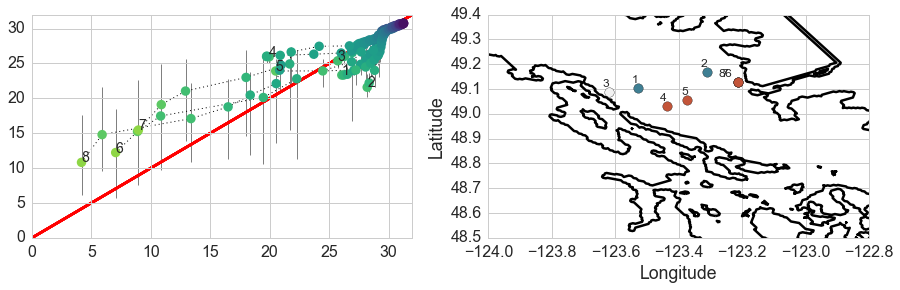

In [22]:
month = 10
lon_min=-123.622
lon_max=-123.2
lat_min=49.
lat_max=49.19
fig1,ax1 = compare_region(data_fall, month,lon_min, lon_max, lat_min, lat_max, paths['RFdaily'],'')


/data/jieliu/MEOPAR/IOS/oct1e05/1h_Plume1_T.nc
Too fresh at depth 3.50003051758, -123.527, 49.1026666667, 2014-10-01 00:00:00
/data/jieliu/MEOPAR/IOS/oct1e05/1h_Plume2_T.nc
Too fresh at depth 3.50003051758, -123.310333333, 49.1673333333, 2014-10-01 00:00:00
/data/jieliu/MEOPAR/IOS/oct1e05/1h_Plume6_T.nc
Salinity within 1 at depth 3.50003051758, -123.62, 49.0896666667, 2014-10-03 00:00:00
/data/jieliu/MEOPAR/IOS/oct1e05/1h_Plume11_T.nc
Too salty at depth 3.50003051758, -123.4385, 49.03, 2014-10-28 00:00:00
/data/jieliu/MEOPAR/IOS/oct1e05/1h_Plume12_T.nc
Salinity within 1 at depth 2.50001144409, -123.372666667, 49.0546666667, 2014-10-28 00:00:00
/data/jieliu/MEOPAR/IOS/oct1e05/1h_Plume40_T.nc
Salinity within 1 at depth 1.50000309944, -123.2119, 49.1292, 2014-10-02 00:00:00
/data/jieliu/MEOPAR/IOS/oct1e05/1h_Plume40_T.nc
Too salty at depth 1.50000309944, -123.2119, 49.1292, 2014-10-14 00:00:00
/data/jieliu/MEOPAR/IOS/oct1e05/1h_Plume40_T.nc
Too salty at depth 1.50000309944, -123.2119, 49.

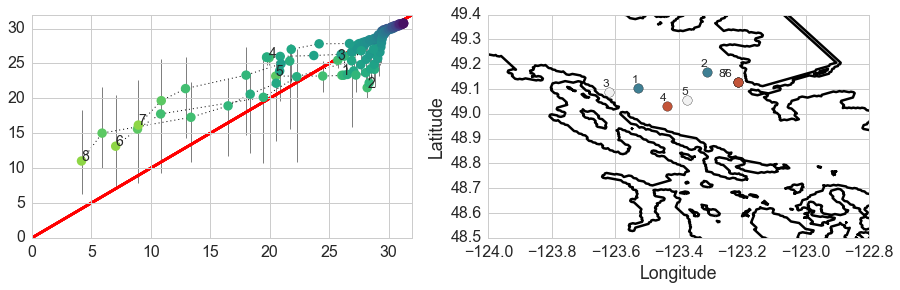

In [23]:
fig1,ax1 = compare_region(data_fall, month,lon_min, lon_max, lat_min, lat_max, paths['1e-05'],'')


# Plot

/data/jieliu/MEOPAR/IOS/oct1e061e05/1h_Plume1_T.nc
Too fresh at depth 3.50003051758, -123.527, 49.1026666667, 2014-10-01 00:00:00
/data/jieliu/MEOPAR/IOS/oct1e061e05/1h_Plume2_T.nc
Too fresh at depth 3.50003051758, -123.310333333, 49.1673333333, 2014-10-01 00:00:00
/data/jieliu/MEOPAR/IOS/oct1e061e05/1h_Plume6_T.nc
Salinity within 1 at depth 3.50003051758, -123.62, 49.0896666667, 2014-10-03 00:00:00
/data/jieliu/MEOPAR/IOS/oct1e061e05/1h_Plume11_T.nc
Too salty at depth 3.50003051758, -123.4385, 49.03, 2014-10-28 00:00:00
/data/jieliu/MEOPAR/IOS/oct1e061e05/1h_Plume12_T.nc
Too salty at depth 2.50001144409, -123.372666667, 49.0546666667, 2014-10-28 00:00:00
/data/jieliu/MEOPAR/IOS/oct1e061e05/1h_Plume40_T.nc
Salinity within 1 at depth 1.50000309944, -123.2119, 49.1292, 2014-10-02 00:00:00
/data/jieliu/MEOPAR/IOS/oct1e061e05/1h_Plume40_T.nc
Too salty at depth 1.50000309944, -123.2119, 49.1292, 2014-10-14 00:00:00
/data/jieliu/MEOPAR/IOS/oct1e061e05/1h_Plume40_T.nc
Too salty at depth 1.500

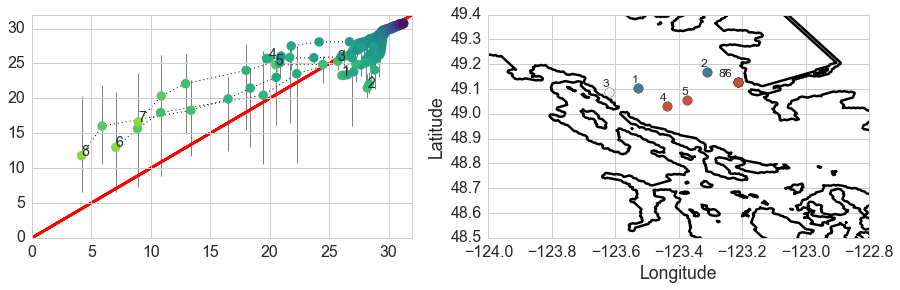

In [24]:
fig1,ax1 = compare_region(data_fall, month,lon_min, lon_max, lat_min, lat_max, paths['1e-051e-06'],'')
